
### 2. Object Detection

2.1 Dataset: Use the oxford_iiit_pet dataset from Keras or PyTorch.

• For object detection, you wil need to find bounding boxes that correspond to the pet objects in the segmentation masks. To create a bounding box for each pet, you can:

• Identify the non-background pixels in the segmentation mask.

• Compute the minimum and maximum coordinates (xmin, xmax, ymin, ymax) that enclose all the pet pixels. This will give you a bounding box for each image around the pet object.

• Example of how to calculate bounding boxes from segmentation masks:

In [5]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models

dataset, info = tfds.load('oxford_iiit_pet', with_info=True, as_supervised=False)

print("Information about the dataset")
print(dataset)

Information about the dataset
{'train': <_PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>, 'test': <_PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>}


In [2]:
train_dataset = dataset['train']
test_dataset = dataset['test']

In [6]:
def get_bounding_box(segmentation_mask):

    # Find non-zero regions in the segmentation mask (i.e., the pet area)
    pet_pixels = np.argwhere(segmentation_mask > 2)

#     # If no pet pixels are found, return None
#     if pet_pixels.size == 0:
#         return None

    # Compute the bounding box coordinates
    ymin = np.min(pet_pixels[:, 0])  # Minimum y-coordinate
    ymax = np.max(pet_pixels[:, 0])  # Maximum y-coordinate
    xmin = np.min(pet_pixels[:, 1])  # Minimum x-coordinate
    xmax = np.max(pet_pixels[:, 1])  # Maximum x-coordinate
    box = xmin, ymin, xmax, ymax
    return box

Mask contains unique values: [1 2 3]
Detected Breed: Sphynx


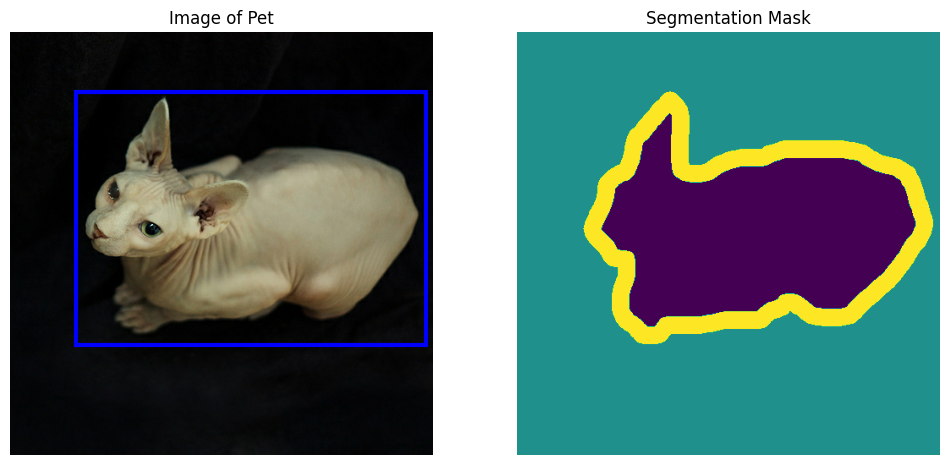

Mask contains unique values: [1 2 3]
Detected Breed: english_cocker_spaniel


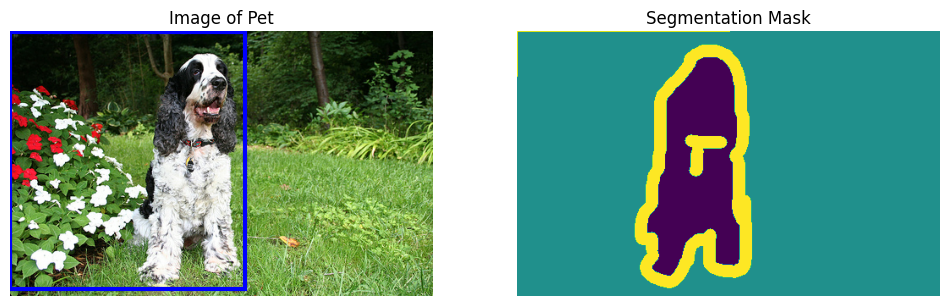

Mask contains unique values: [1 2 3]
Detected Breed: British_Shorthair


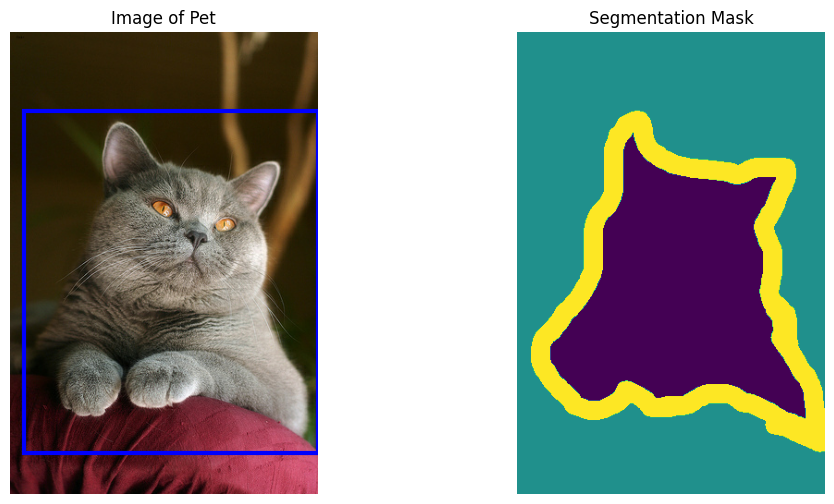

Mask contains unique values: [1 2 3]
Detected Breed: Siamese


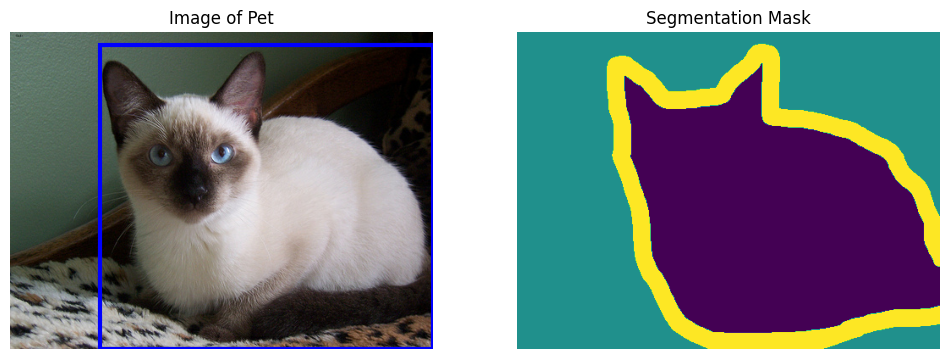

Mask contains unique values: [1 2 3]
Detected Breed: Sphynx


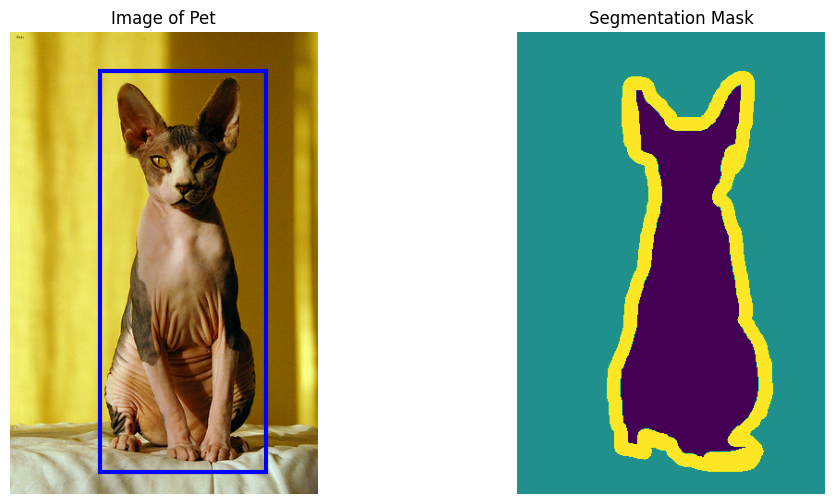

In [7]:
import cv2

def visualize_pet_segmentation_with_contours(data_sample):
    # Load the image and segmentation mask
    img = data_sample['image']
    segmentation = data_sample['segmentation_mask'].numpy().squeeze()
    pet_label = data_sample['label']

    # Print unique values in the segmentation mask
    unique_classes = np.unique(segmentation)
    print(f"Mask contains unique values: {unique_classes}")

    # Convert the segmentation mask to a binary mask for contour detection
    binary_mask = np.where(segmentation == 3, 255, 0).astype(np.uint8)

    # Find contours in the binary mask
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Initialize bounding box coordinates
    xmin, ymin, xmax, ymax = None, None, None, None

    # Loop through contours to get bounding box coordinates
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if xmin is None or x < xmin:
            xmin = x
        if ymin is None or y < ymin:
            ymin = y
        if xmax is None or (x + w) > xmax:
            xmax = x + w
        if ymax is None or (y + h) > ymax:
            ymax = y + h

    # Get the pet breed name
    pet_type = info.features['label'].int2str(pet_label)
    print(f"Detected Breed: {pet_type}")

    # Create a new figure for displaying results
    plt.figure(figsize=(12, 6))

    # Display the original image
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Image of Pet")
    plt.axis('off')

    # Draw the bounding box if valid coordinates were found
    if xmin is not None and xmax is not None and ymin is not None and ymax is not None:
        plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                           edgecolor='blue', linewidth=3, fill=False))
    else:
        print("No bounding box could be determined.")

    # Display the segmentation mask
    plt.subplot(1, 2, 2)
    plt.imshow(segmentation, cmap='viridis')
    plt.title("Segmentation Mask")
    plt.axis('off')

    plt.show()

# Call the modified function on samples
for sample in train_dataset.take(5):
    visualize_pet_segmentation_with_contours(sample)